In [1]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from fastai.imports import *
from fastai.structured import *
np.random.seed(14)

In [2]:
df = pd.read_csv("assets/rspb20170679_si_005.csv")

df.columns = ["Year","Pencillin(R)", "Erythromycin(R)","Multidrug(R)","Amoxicillin(C)",
              "Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)","Cephalosporins(C)",
              "Azithromycin(C)","ConcTotal(C)"]
df = df.set_index("Year")
df.head(2)

,Pencillin(R),Erythromycin(R),Multidrug(R),Amoxicillin(C),Amoxicillin-Clavunate(C),Amoxicillin-Total(C),Cephalosporins(C),Azithromycin(C),ConcTotal(C)
Year,,,,,,,,,
1999.000000,19.9071,0.00000,0.050406,222.186,67.4306,289.6166,37.6809,4.12793,358.506
1999.083333,47.2212,2.51094,9.361640,251.312,71.1567,322.4687,25.5851,2.61499,382.361


In [55]:
df.shape

(60, 9)

In [3]:
Multidrug_X = df[["Multidrug(R)",
                 "Azithromycin(C)","Amoxicillin-Total(C)"]].values
Erythromycin_X = df[["Erythromycin(R)",
                 "Azithromycin(C)","Amoxicillin-Total(C)"]].values
Pencillin_x = df[["Pencillin(R)","Cephalosporins(C)",
                 "Azithromycin(C)"]].values

In [4]:
#Pencillin_x = df[["Pencillin(R)","Cephalosporins(C)","Azithromycin(C)"]].values

In [5]:
#Multidrug_X = df[["Multidrug(R)","Cephalosporins(C)"]].values

In [6]:
def train_data(data, num_periods=7, f_horizon=1, scale=False):    
    n, m = data.shape

    x_data = data[:(len(data) - (len(data) % num_periods))]
    y_data = data[1:(len(data)-(len(data) % num_periods)) + f_horizon]
    
    if scale:
        std_scale = preprocessing.StandardScaler().fit(x_data, y_data)
        x_data = std_scale.transform(x_data)
        y_data = std_scale.transform(y_data)
    
    
    
    x_batches = x_data.reshape(-1, num_periods, m)
    y_batches = y_data.reshape(-1, num_periods, m)
    
    if scale:
        return x_batches, y_batches, std_scale
    else:
        return x_batches, y_batches

In [7]:
def test_data(data, num_periods, forecast, std_scale=None):
    n,m = data.shape
    
    test_x_setup = data[-(num_periods +  forecast):]
    
    if std_scale:
        test_x_setup = std_scale.transform(test_x_setup)
    
    testX = test_x_setup[:num_periods].reshape(-1, num_periods, m)
    
    if std_scale:
        testY = std_scale.transform(data[-(num_periods):]).reshape(-1, num_periods, m)
    else:
        testY = data[-(num_periods):].reshape(-1, num_periods, m)
    return testX, testY

In [8]:
from tensorflow.contrib.distributions import Bernoulli

class StochasticRNNLayer:
    """
    StochasticLayer Dense Layer.

    Parameters
    ----------
    BN : bool
        Batchnormalization
    n_in : int
        Input nodes
    n_out: int
        Output nodes
    model_prob: float
        Dropout probability
    model_lam: float
        regualarization term
    is_training: bool
        traing-phase/test-phase        
    
    Returns
    -------
    array
        Outputlayer
    """
    

    def __init__(self, n_in, n_out, model_prob, model_lam, is_training, BN=False, decay=0.99):
        
        
        self.n_in = n_in
        self.n_out = n_out
        
        self.is_training = is_training    
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )
        
        #Parameters for BatchNormalization
        self.BN = BN
        self.scale = tf.Variable(tf.ones([n_out]))
        self.beta = tf.Variable(tf.zeros([n_out]))
        self.epsilon = 1e-2
        self.mean = tf.Variable(tf.zeros([n_out]), trainable=False)
        self.var = tf.Variable(tf.ones([n_out]), trainable=False)
        self.decay = decay

    def __call__(self, X, activation=tf.identity):
        
        basic_cell = tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.BasicRNNCell(num_units=self.n_in, activation=tf.nn.relu),
            output_size=self.n_in
        )
        
            
        rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
        

        #rnn_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(self.n_in), tf.contrib.rnn.BasicLSTMCell(self.n_in)])
        #outputs, states = tf.contrib.rnn.static_rnn(rnn_cell, X, dtype=tf.float32)
            
        #print("rnn_output",rnn_output.shape)
        output = tf.reshape(rnn_output, [-1, self.n_in])
        
        #output = outputs[-1]
        
        
        #output = rnn_output
        #print("data",X.shape)
        #print("output",output.shape)
        #print("mask",self.model_W.shape)
        output = activation(tf.matmul(output, self.model_W) + self.model_m)
        
        if self.BN:
            output = self.batch_norm_wrapper(output)
                
        #if self.model_M.shape[1] == m:
        #    output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        """regularization"""

        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

    
    
    def batch_norm_wrapper(self, inputs):
        """
        Batchnormalization

        Parameters
        ----------
        inputs : array
            Batch input
        is_training : bool
            training phase/test phase
        decay: float
            Decrease training of popoulation mean and variance.    
        Returns
        -------
        array
            Normalized batched
        """
        
        
        
        def BN_train():
            """
            Batchnormalization training
 
            Returns
            -------
            array
                Normalized train batch
            """
            batch_mean, batch_var = tf.nn.moments(inputs,[0])
            train_mean = tf.assign(self.mean, self.mean * self.decay + batch_mean * (1 - self.decay))
            train_var = tf.assign(self.var, self.var * self.decay + batch_var * (1 - self.decay))
            #train_mean = tf.assign(self.mean, self.mean + batch_mean)
            #train_var = tf.assign(self.var, self.var + batch_var)
            
            with tf.control_dependencies([train_mean, train_var]):
                return tf.nn.batch_normalization(inputs,
                    batch_mean, batch_var, self.beta, self.scale, self.epsilon)
            
        def BN_test():
            """
            Batchnormalization test
 
            Returns
            -------
            array
                Normalized test batched
            """
            return tf.nn.batch_normalization(inputs,
                self.mean, self.var, self.beta, self.scale, self.epsilon)
        
        
        return tf.cond(self.is_training, BN_train, BN_test)

In [9]:
def build_graph(num_periods, features, dp_prob=1.0, BN=False, decay=0.99,hidden=100,bs=10, model_lam=1e-2):
    #num_periods = x_batches.shape[1]
    inputs = features
    hidden = hidden
    #output = features
    output = 1
    model_prob = dp_prob
    model_lam = model_lam



    X = tf.placeholder(tf.float32, [None, num_periods, inputs])
    
    #X = tf.reshape(z, [-1, num_periods*inputs])
    #X = tf.split(X, num_periods, 1)
    
    
    y = tf.placeholder(tf.float32, [None, num_periods, output])

    is_training = tf.placeholder(tf.bool)
    
    Layer_1 = StochasticRNNLayer(hidden, hidden, model_prob, model_lam, is_training ,BN=BN, decay=decay)

    z_1 = Layer_1(X, tf.nn.relu)


    learning_rate = 0.001
    


    stacked_outputs = tf.layers.dense(z_1, output)
    y_pred = tf.reshape(stacked_outputs, [-1, num_periods, output])
    
    sse = tf.reduce_sum(tf.square(y_pred - y)) 

    mse = sse / bs
    
    model_loss = (
        # Negative log-likelihood.
        sse +
        # Regularization.
        Layer_1.regularization 
        
                ) / bs
    
    
    train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(model_loss)

    return (X, y), train_step, mse, y_pred, tf.train.Saver(), is_training


In [10]:
def train(x_batches,y_batch,iterations=2000, verbose =True, bs=10):
    """
    Train model

    Parameters
    ----------
    iterations : int
        Number of iterations
    verbose : bool
        Verbose
    bs: int
        batch-size
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(iterations):
            #Run it in batches.
            test_idx = np.arange(0 , len(x_batches[1]))
            #np.random.shuffle(test_idx)
            X_batch = x_batches[test_idx[:bs]]
            y_batch = y_batches[test_idx[:bs]]
        
        
            train_step.run(feed_dict={X_input: X_batch, y_input: y_batch, is_training:True})
            if verbose:
                if i % 100 == 0:
                    print(i)
                    mse = sess.run(model_mse, {X_input: X_batch, y_input: y_batch, is_training:True})
                    print("Iteration {}, Mean squared errror: {:.7f}".format(i, mse))
        saved_model = saver.save(sess, 'temp/temp-bn-save')
        sess.close()

In [11]:
def test(x_batches,X_test,features,samples=1000, bs=10,BN=False):
    """
    Test model

    Parameters
    ----------
    samples : int
        Monte Carlo Samples
    bs : int
        Batchnorm samples
    """
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, 'temp/temp-bn-save')
    

        Y_sample = np.zeros((samples, x_batches.shape[1], features))
        for i in range(samples):       
            if BN:
                test_idx = np.arange(0 , x_batches.shape[0])
                np.random.shuffle(test_idx)
                model_pred.eval({X_input: x_batches[test_idx[:bs]],  is_training: True})
            Y_sample[i] = sess.run(model_pred, {X_input: X_test, is_training: False})
        return Y_sample

In [12]:
def plot(y_samples, y_test):
    if True:
        plt.figure(figsize=(8,6))
    for i in range(samples):
        plt.plot(pd.Series(np.ravel(y_samples[i])), "b-", alpha=1. / 200)
    plt.plot(pd.Series(np.ravel(y_test)), "ro", markersize=10, label="Actual")

# BDNN Multidrug rescistance Forecasting 

In [13]:
decay=0.8
bs = 5
dp_prob = 0.25
BN=True
hidden= 500
samples = 3000
iterations=  5 * 1000
model_lam = 1e-1

In [14]:
num_periods, f_horizon = 7, 1
features = Multidrug_X.shape[1]

In [15]:
x_batches, y_batches = train_data(Multidrug_X, num_periods=num_periods, f_horizon=f_horizon)
X_test, Y_test = test_data(Multidrug_X, num_periods,f_horizon)

In [16]:
y_batches = np.expand_dims(y_batches[:,:,0],2)
Y_test = np.expand_dims(Y_test[:,:,0],2)

In [17]:
np.min(x_batches,axis=2).shape

(8, 7)

In [18]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, _, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,model_lam=model_lam
                                                                              )
train(x_batches, y_batches, iterations=iterations,verbose = True, bs=bs)

0
Iteration 0, Mean squared errror: 2904.2202148
100
Iteration 100, Mean squared errror: 1064.9597168
200
Iteration 200, Mean squared errror: 56.5893021
300
Iteration 300, Mean squared errror: 27.2366333
400
Iteration 400, Mean squared errror: 14.9301176
500
Iteration 500, Mean squared errror: 12.7333345
600
Iteration 600, Mean squared errror: 16.4726295
700
Iteration 700, Mean squared errror: 13.2735367
800
Iteration 800, Mean squared errror: 22.0674744
900
Iteration 900, Mean squared errror: 6.6465745
1000
Iteration 1000, Mean squared errror: 3.0963628
1100
Iteration 1100, Mean squared errror: 3.1804569
1200
Iteration 1200, Mean squared errror: 3.9131279
1300
Iteration 1300, Mean squared errror: 2.1984599
1400
Iteration 1400, Mean squared errror: 8.9298954
1500
Iteration 1500, Mean squared errror: 2.2240489
1600
Iteration 1600, Mean squared errror: 2.3990257
1700
Iteration 1700, Mean squared errror: 2.2571547
1800
Iteration 1800, Mean squared errror: 2.3163419
1900
Iteration 1900, Me

In [19]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, model_pred, saver, is_training = build_graph(num_periods,features,
                                                                                        BN=BN,decay=decay,
                                                                                        dp_prob=dp_prob,hidden=hidden,
                                                                                       model_lam=model_lam
                                                                                       )
Y_sample_DP = test(x_batches,X_test,features,samples, bs=bs,BN=BN)

INFO:tensorflow:Restoring parameters from temp/temp-bn-save


In [20]:
Y_sample_DP = np.expand_dims(Y_sample_DP[:,:,0],-1)
Y_test = np.expand_dims(Y_test[:,:,0],-1)

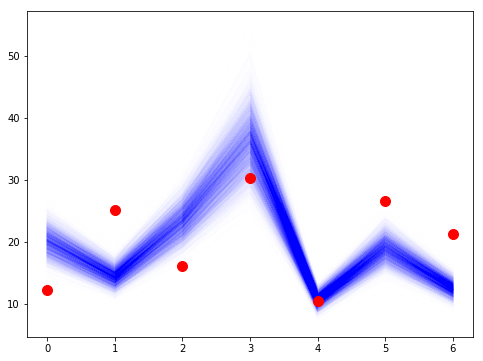

In [21]:
plot(Y_sample_DP, Y_test)

# BDNN Erythromycin rescistance Forecasting 


In [22]:
decay=0.9
bs = 5
dp_prob = 0.15
BN=True
hidden= 500
samples = 3000
iterations=  5 * 1000
model_lam = 1e-1

In [23]:

num_periods, f_horizon = 7, 1
features = Erythromycin_X.shape[1]

In [24]:
x_batches, y_batches = train_data(Erythromycin_X, num_periods=num_periods, f_horizon=f_horizon)
X_test, Y_test = test_data(Erythromycin_X, num_periods,f_horizon)

In [25]:
y_batches = np.expand_dims(y_batches[:,:,0],2)
Y_test = np.expand_dims(Y_test[:,:,0],2)

In [26]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, _, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,model_lam=model_lam
                                                                              )
train(x_batches, y_batches, iterations=iterations,verbose = True, bs=bs)

0
Iteration 0, Mean squared errror: 2439.5744629
100
Iteration 100, Mean squared errror: 888.7642822
200
Iteration 200, Mean squared errror: 106.3861465
300
Iteration 300, Mean squared errror: 95.8508072
400
Iteration 400, Mean squared errror: 40.6630783
500
Iteration 500, Mean squared errror: 28.5499153
600
Iteration 600, Mean squared errror: 25.9170475
700
Iteration 700, Mean squared errror: 18.0787239
800
Iteration 800, Mean squared errror: 11.6385889
900
Iteration 900, Mean squared errror: 17.5270386
1000
Iteration 1000, Mean squared errror: 3.1435754
1100
Iteration 1100, Mean squared errror: 7.7679968
1200
Iteration 1200, Mean squared errror: 4.3245721
1300
Iteration 1300, Mean squared errror: 5.0797143
1400
Iteration 1400, Mean squared errror: 4.2503805
1500
Iteration 1500, Mean squared errror: 2.0587804
1600
Iteration 1600, Mean squared errror: 3.6857827
1700
Iteration 1700, Mean squared errror: 2.0309243
1800
Iteration 1800, Mean squared errror: 6.3964748
1900
Iteration 1900, M

In [27]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, model_pred, saver, is_training = build_graph(num_periods,features,
                                                                                        BN=BN,decay=decay,
                                                                                        dp_prob=dp_prob,hidden=hidden,
                                                                                       model_lam=model_lam
                                                                                       )
Y_sample_DP = test(x_batches,X_test,features,samples, bs=bs,BN=BN)

INFO:tensorflow:Restoring parameters from temp/temp-bn-save


In [28]:
Y_sample_DP = np.expand_dims(Y_sample_DP[:,:,0],-1)
Y_test = np.expand_dims(Y_test[:,:,0],-1)

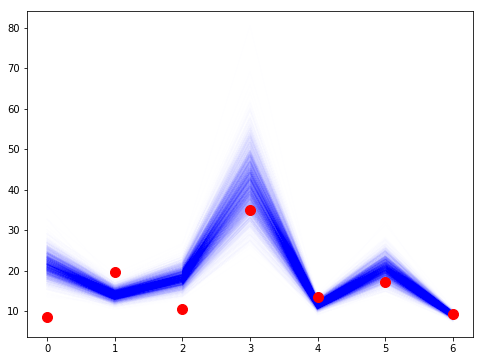

In [29]:
plot(Y_sample_DP, Y_test)

# BDNN Pencillin rescistance Forecasting 


In [ ]:
decay=0.9
bs = 5
dp_prob = 0.95
BN=True
hidden= 500
samples = 3000
iterations=  5 * 1000
model_lam = 1e-6

In [ ]:
num_periods, f_horizon = 7, 1
features = Pencillin_x.shape[1]

In [ ]:
x_batches, y_batches = train_data(Pencillin_x, num_periods=num_periods, f_horizon=f_horizon)
X_test, Y_test = test_data(Pencillin_x, num_periods,f_horizon)

In [ ]:
y_batches = np.expand_dims(y_batches[:,:,0],2)
Y_test = np.expand_dims(Y_test[:,:,0],2)

In [ ]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, _, saver, is_training = build_graph(num_periods,features,
                                                                BN=BN,decay=decay,dp_prob=dp_prob,hidden=hidden,
                                                                bs=bs,model_lam=model_lam
                                                                              )
train(x_batches, y_batches, iterations=iterations,verbose = True, bs=bs)

In [ ]:
tf.reset_default_graph()
(X_input, y_input), train_step, model_mse, model_pred, saver, is_training = build_graph(num_periods,features,
                                                                                        BN=BN,decay=decay,
                                                                                        dp_prob=dp_prob,hidden=hidden,
                                                                                       model_lam=model_lam
                                                                                       )
Y_sample_DP = test(x_batches,X_test,features,samples, bs=bs,BN=BN)

In [ ]:
Y_sample_DP = np.expand_dims(Y_sample_DP[:,:,0],-1)
Y_test = np.expand_dims(Y_test[:,:,0],-1)

In [ ]:
plot(Y_sample_DP, Y_test)